<a href="https://colab.research.google.com/github/ELBrown11/StarbucksCapstoneChallenge/blob/main/Starbucks_Capstone_notebook_DataPrep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Starbucks Capstone Challenge

**Project Summary: Starbucks Customer Behavior Analysis**

This project involves analyzing simulated data from the Starbucks rewards app to understand how different customer demographics respond to different types of offers (e.g., discounts, BOGO, or informational ads).

**Key Components:**
- **Data Sources**: Transactional data, demographic info, and offer data.
- **Goal**: Determine which demographic groups respond best to specific offer types.
  - develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A)
- **Offers**: Sent periodically to users and can vary in type and duration. Some users receive no offers.
- **Behavioral Challenge**: Users can complete offers without viewing them, meaning they weren't truly influenced by the offer.

**Considerations:**
- View vs. complete behavior matters (a completed offer without being viewed may not be due to the offer).
- Some users buy without offers; targeting those users with discounts may not be cost-effective.
- Offer effectiveness depends on timing, demographics, and user engagement.

**Approach**: rule-based heuristics, or exploratory data analysis to uncover insights and make recommendations.


-----

##Resources
* https://corporatefinanceinstitute.com/resources/wealth-management/heuristics/
* https://www.investopedia.com/terms/h/heuristics.asp





# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


#Data Dictionary

**portfolio.json**

Offers sent during 30-day test period (10 offers x 6 fields)

    reward: (numeric) money awarded for the amount spent
    channels: (list) web, email, mobile, social
    difficulty: (numeric) money required to be spent to receive reward
    duration: (numeric) time for offer to be open, in days
    offer_type: (string) bogo, discount, informational
    id: (string/hash)

**profile.json**

Rewards program users (17000 users x 5 fields)

    gender: (categorical) M, F, O, or null
    age: (numeric) missing value encoded as 118
    id: (string/hash)
    became_member_on: (date) format YYYYMMDD
    income: (numeric)

**transcript.json**

Event log (306648 events x 4 fields)

    person: (string/hash)
    event: (string) offer received, offer viewed, transaction, offer completed
    value: (dictionary) different values depending on event type
        offer id: (string/hash) not associated with any "transaction"
        amount: (numeric) money spent in "transaction"
        reward: (numeric) money gained from "offer completed"
    time: (numeric) hours after start of test

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import gc



%matplotlib inline



# **Read In JSON Files**

In [2]:
# read in the json files
portfolio = pd.read_json('/content/drive/MyDrive/Udacity DS Nanodegree/Capstone Project/Data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('/content/drive/MyDrive/Udacity DS Nanodegree/Capstone Project/Data/profile.json', orient='records', lines=True)
transcript = pd.read_json('/content/drive/MyDrive/Udacity DS Nanodegree/Capstone Project/Data/transcript.json', orient='records', lines=True)

# **Data Exploration**

## **Portfolio.json**

In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 612.0+ bytes


In [4]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
portfolio.isnull().sum()

,0
reward,0
channels,0
difficulty,0
duration,0
offer_type,0
id,0


### **exploring different offer types and the distribution**

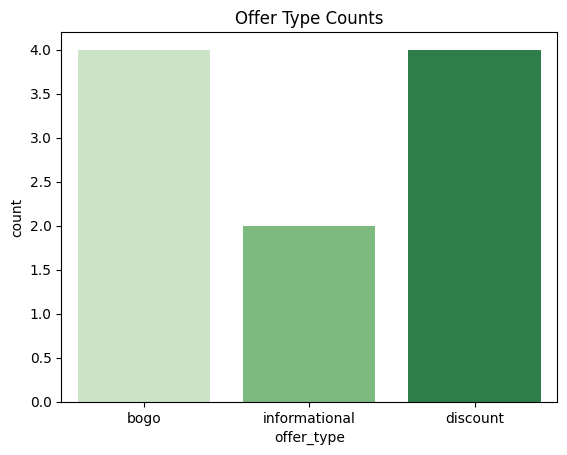

In [ ]:
#count of each offer types
sns.countplot(x='offer_type',data=portfolio, hue='offer_type',palette='Greens')
plt.title('Offer Type Counts')
plt.show();

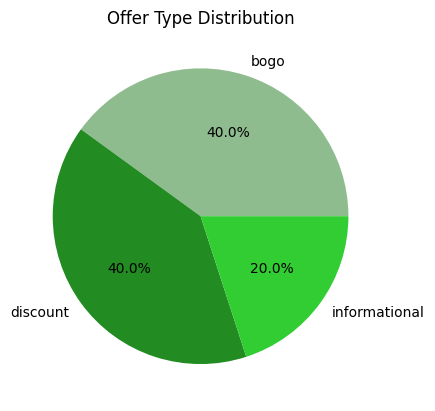

In [ ]:
plt.pie(portfolio['offer_type'].value_counts(), labels=portfolio['offer_type'].value_counts().index,
        colors=['darkseagreen', 'forestgreen', 'limegreen'], autopct='%1.1f%%')

plt.title('Offer Type Distribution')
plt.show();

## **Profile Data**

In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [ ]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [7]:
profile.isnull().sum()

,0
gender,2175
age,0
id,0
became_member_on,0
income,2175


In [12]:
profile.isnull().sum()/len(profile)*100

,0
gender,12.794118
age,0.000000
id,0.000000
became_member_on,0.000000
income,12.794118


In [14]:
profile.isnull().sum()

,0
gender,2175
age,0
id,0
became_member_on,0
income,2175


### **exploring demographic data distributions**

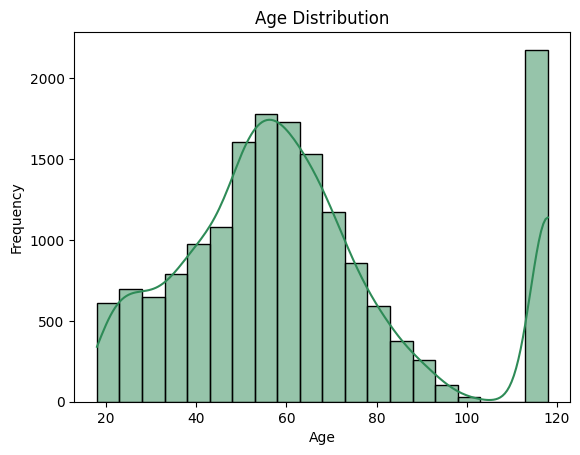

In [ ]:
sns.histplot(profile['age'].dropna(), bins=20, kde=True, color='seagreen')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show();

- here we can see the ages are almost normal distributed but there's an outlier

In [ ]:
profile['age'].describe()

,age
count,17000.000000
mean,62.531412
std,26.738580
min,18.000000
25%,45.000000
50%,58.000000
75%,73.000000
max,118.000000


In [ ]:
(profile[profile['age'] == 118]).shape

(2175, 5)

- there are 2175 rows where people are 118 years old but it is unlikely that these are the users' true ages so they should be dropped during data cleaning

In [ ]:
hunnids = profile[(profile['age'] >= 100)]
hunnids['age'].value_counts()

,count
age,
118,2175
100,12
101,5


- we see that there are 12 people that are 100 and 5 who are 101 this seems more likely than 2000+ people older than 101 using the app
  - likely people who put in a birthday randomly or incorrectly
  

### **Exploring Extreme Age and Missing Gender and Income Data**

In [19]:
extreme_age_rows = profile[(profile['age'] > 101 )]
extreme_age_indices = set(extreme_age_rows.index)
missing_gender_income_rows = profile[profile['gender'].isna() & profile['income'].isna()]
missing_gender_income_indices = set(missing_gender_income_rows.index)

are_same = extreme_age_indices == missing_gender_income_indices
print(f'are the sets of rows the same? {are_same}')


are the sets of rows the same? True


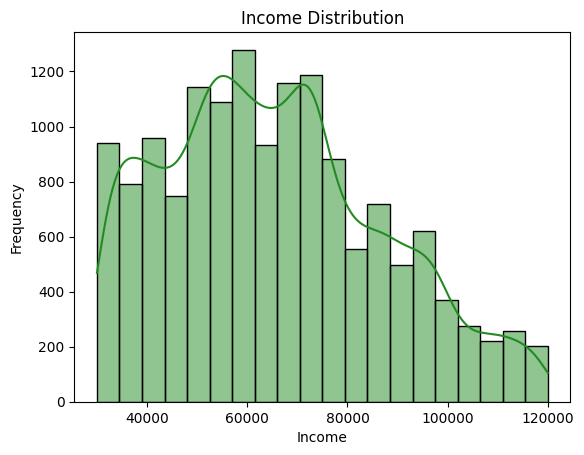

In [ ]:
sns.histplot(profile['income'].dropna(), bins=20, kde=True, color='forestgreen')
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show();

- right skewd income distribution
  - mean > median
  - most people earn average salaries and few are rich


In [ ]:
income_mean = profile['income'].mean()
income_median = profile['income'].median()
print(f'Average Income: ${income_mean:.2f}')
print(f'Median Income: ${income_median:.2f}')
print(income_mean > income_median)

Average Income: $65404.99
Median Income: $64000.00
True


- checking that the math matches it being right skewed

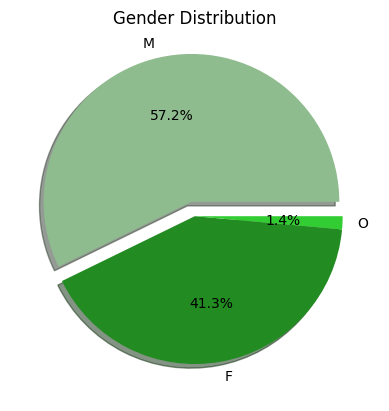

In [ ]:
explode = (0.1, 0, 0)
plt.pie(profile['gender'].value_counts(), labels=profile['gender'].value_counts().index,
        colors=['darkseagreen', 'forestgreen', 'limegreen'],explode=explode, autopct='%1.1f%%', shadow=True)
plt.title('Gender Distribution')
plt.show();

- early hypothesis: even though there are more male users in this data set i think that the female and possible other will be more responsive to the offers

## **Transcript Data**

In [ ]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [ ]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [8]:
transcript.isnull().sum()

,0
person,0
event,0
value,0
time,0


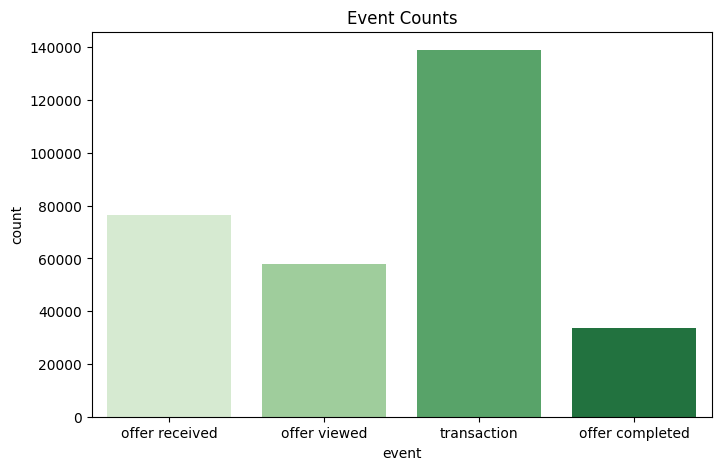

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=transcript, x='event',hue='event', palette='Greens')
plt.title('Event Counts')
plt.show();


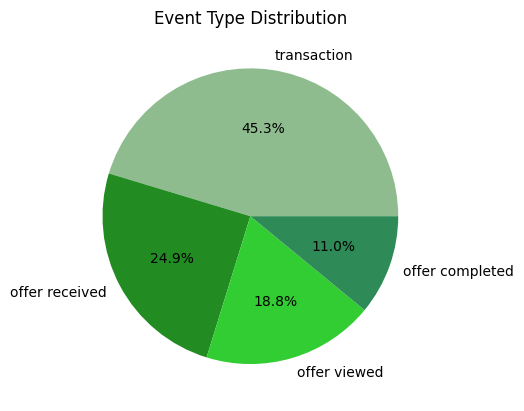

In [5]:
plt.pie(transcript['event'].value_counts(), labels=transcript['event'].value_counts().index,
        colors=['darkseagreen', 'forestgreen', 'limegreen','seagreen'], autopct='%1.1f%%')

plt.title('Event Type Distribution')
plt.show();

In [ ]:
transcript['value'].value_counts()

,count
value,
{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},14374
...,...
{'amount': 855.31},1
{'amount': 48.09},1
{'amount': 125.41},1


- value column contains dictionary/key pairs
- value column contains different key pair based on event type
  - event types = offer received, offer viewed, transaction, offer completed
  - transaction means that there is no interaction with offer
    - have the greatest number of all events
  - if key pair start;s with offer id - there's no transaction, data is just offer id
  - if key pair is amount - data is money spent during transaction (any event)
  - if key pair is reward - data is money from offer completed
    - this mean offer was received but maybe offer viewed was skipped
- need to expand the value column to get this extra data that related to events

In [6]:
transcript['time'].value_counts()

,count
time,
408,17030
576,17015
504,16822
336,16302
168,16150
...,...
318,940
330,938
156,914


# **Data Cleaning**

## **Portfolio Dataframe**

In [3]:
def preprocess_portfolio(df):
    """
    Preprocess the portfolio DataFrame from the Starbucks dataset.

    Steps:
    - Renames 'id' to 'offer_id' for consistency across dataframes
    - Drops columns 'reward', 'channels', 'difficulty', and 'duration'
    - Returns a cleaned and expanded DataFrame

    Parameters:
    - df: raw portfolio DataFrame

    Returns:
    - portfolio_expanded: cleaned and expanded portfolio DataFrame
    """
    #make a copy to avoid modifying the original DataFrame
    df = df.copy()

    #rename columns
    df.rename(columns={'id': 'offer_id'}, inplace=True)

    #drop columns
    df.drop(columns=['reward','channels','difficulty','duration'], inplace=True)

    return df


portfolio = preprocess_portfolio(portfolio)
portfolio.head()

,offer_type,offer_id
0,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,informational,3f207df678b143eea3cee63160fa8bed
3,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


## **Profile Dataset**

In [4]:
def preprocess_profile(df):
    """
    Preprocess the Starbucks profile DataFrame.

    Steps:
    - converts 'became_member_on' to datetime
    - filters for ages outside of reasonable bounds (e.g., negative ages or people older than 101)
      - this also gets rid of rows with missing gender and income data bc they're the same rows
    - renames 'id' to 'user_id' for clarity

    Parameters:
    - df: raw transcript DataFrame

    Returns:
    - df: cleaned transcript DataFrame

    """

    #create a copy of the DataFrame to avoid the SettingWithCopyWarning
    df = df.copy()

    #convert 'became_member_on' to datetime
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')

    #check for ages outside of reasonable bounds (e.g., negative ages or extremely old ages).
    df = df[(df['age'] >= 0) & (df['age'] <= 101)]

    #change id to user_id
    df.rename(columns={'id': 'user_id'}, inplace=True)


    return df

profile = preprocess_profile(profile)
profile.head()

,gender,age,user_id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


## **Transcript DataFrame**

In [5]:
def preprocess_transcript(df):
    """
    Preprocess the transcript DataFrame from the Starbucks dataset.

    Steps:
    - expands the 'value' column (which contains dictionaries) into separate columns:
        - Extracts 'offer id', 'amount', and 'reward' if present
    - standardizes column names:
        - renames 'offer id' to 'offer_id'
        - renames 'person' to 'user_id'
    - drops columns 'time', 'reward', 'amount'



    Parameters:
    - df: raw transcript DataFrame

    Returns:
    - df: cleaned and expanded transcript DataFrame
    """
    #expand the 'value' dictionary into separate columns
    value_df = df['value'].apply(pd.Series)
    df = df.drop(columns='value').join(value_df)

    #standardize 'offer id' to 'offer_id'
    if 'offer id' in df.columns:
        df['offer_id'] = df['offer_id'].combine_first(df['offer id'])
        df.drop(columns='offer id', inplace=True)

    #rename 'person' to 'user_id'
    df.rename(columns={'person': 'user_id'}, inplace=True)

    #drop column
    df.drop(columns=['reward','amount'], inplace=True)

    return df


transcript = preprocess_transcript(transcript)
transcript.head()

,user_id,event,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0


In [8]:
#print column names of each dataframe

print("Portfolio DataFrame Columns:")
print(portfolio.columns.tolist())

print("\nProfile DataFrame Columns:")
print(profile.columns.tolist())

print("\nTranscript DataFrame Columns:")
print(transcript.columns.tolist())



Portfolio DataFrame Columns:
['offer_type', 'offer_id']

Profile DataFrame Columns:
['gender', 'age', 'user_id', 'became_member_on', 'income']

Transcript DataFrame Columns:
['user_id', 'event', 'amount', 'offer_id']


## **function for combining all dataframes**
- create one large dataframe which combines all dataframes on offer_id and user_id

In [6]:
def combine_dataframes(profile_df, portfolio_df, transcript_df):
    """
    Combines profile, portfolio, and transcript dataframes into one enriched dataframe.

    Parameters:
    - profile_df: dataFrame containing user profile information.
    - portfolio_df: dataFrame containing offer metadata (with channels expanded).
    - transcript_df: dataFrame containing user interactions (with offers).

    Returns:
    - combined_df: A merged dataframe combining all three sources.
    """

    # Merge transcript with portfolio on offer_id
    transcript_offer = transcript_df.merge(portfolio_df, on='offer_id', how='left')

    # Merge the result with profile on user_id
    combined_df = transcript_offer.merge(profile_df, on='user_id', how='left')

    return combined_df

combined_df = combine_dataframes(profile, portfolio, transcript)
combined_df.head()

,user_id,event,offer_id,offer_type,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,F,75.0,2017-05-09,100000.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,NaN,NaN,NaT,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,discount,M,68.0,2018-04-26,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,discount,NaN,NaN,NaT,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,NaN,NaN,NaT,NaN


## **Assessing Missing Data**

In [8]:
# 1. Count of missing values per column
combined_df.isnull().sum()

# 2. Percentage of missing values per column
(combined_df.isnull().sum() / len(combined_df)) * 100

# 3. Combine both into one DataFrame for clarity
missing_summary = pd.DataFrame({
    'Missing Count': combined_df.isnull().sum(),
    'Missing %': (combined_df.isnull().sum() / len(combined_df)) * 100
})
print(missing_summary.sort_values('Missing %', ascending=False))

                  Missing Count  Missing %
offer_type               138953  45.330371
offer_id                 138953  45.330371
age                       33772  11.017375
gender                    33772  11.017375
became_member_on          33772  11.017375
income                    33772  11.017375
user_id                       0   0.000000
event                         0   0.000000


- this amount of missing data for `offer_type` and `offer_id` aligns with the fact that during data exploration we saw that ~45% percent of offer types where "tranactions" which means no offer
- ~11% missing for the demographic data isn't insignificant but also isn't and extreme amount so these can be dropped

In [10]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           306534 non-null  object        
 1   event             306534 non-null  object        
 2   amount            138953 non-null  float64       
 3   offer_id          167581 non-null  object        
 4   offer_type        167581 non-null  object        
 5   gender            272762 non-null  object        
 6   age               272762 non-null  float64       
 7   became_member_on  272762 non-null  datetime64[ns]
 8   income            272762 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 21.0+ MB


## **Cleaning Combined DataFrame**

In [ ]:
def clean_combined_data(df):
    """
    Clean and preprocess the combined DataFrame.
    Steps:

    - fill in missing income data with median income
    - convert membership 'time' from hours to days
    - change event, gender, offer_type, and offer_id to category type
    - fill in missing for columns related to channels


    Parameters:
    - fully combined DataFrame

    Returns:
    - combined_df: A merged dataframe combining all three sources.
    """






    #fill in missing income data with median income
    df['income'] = df['income'].fillna(df['income'].median())


    # Convert 'time' to weeks
    df['membership_weeks'] = (df['time'] / (24 * 7)).round(0)


    #creates column that sums number channel users advertised from
    #fill in missing for columns related to channels
    channel_cols = ['web', 'email', 'mobile', 'social']
    df['num_channels'] = df[channel_cols].sum(axis=1)
    df[channel_cols] = df[channel_cols].fillna(0)

    # Convert to category type
    for col in ['event', 'gender', 'offer_type', 'offer_id']:
        df[col] = df[col].astype('category')

    return df

cleaned_df = clean_combined_data(combined_df)
cleaned_df.head()

,user_id,event,time,amount,offer_id,earned_reward,potential_reward,difficulty,duration,offer_type,email,mobile,social,web,gender,age,became_member_on,income,membership_weeks,num_channels
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,F,75.0,2017-05-09,100000.0,0.0,3.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,NaN,NaN,NaT,62000.0,0.0,2.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,M,68.0,2018-04-26,70000.0,0.0,3.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,NaN,NaN,NaT,62000.0,0.0,4.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,NaN,NaN,NaT,62000.0,0.0,4.0


In [ ]:
def clean_combined_data(df):
    """
    Clean and preprocess the combined DataFrame.
    Steps:

    -


    Parameters:
    - fully combined DataFrame

    Returns:
    - combined_df: A merged dataframe combining all three sources.
    """






    #fill in missing income data with median income
    df['income'] = df['income'].fillna(df['income'].median())


    # Convert 'time' to weeks
    df['membership_weeks'] = (df['time'] / (24 * 7)).round(0)


    #creates column that sums number channel users advertised from
    #fill in missing for columns related to channels
    channel_cols = ['web', 'email', 'mobile', 'social']
    df['num_channels'] = df[channel_cols].sum(axis=1)
    df[channel_cols] = df[channel_cols].fillna(0)

    # Convert to category type
    for col in ['event', 'gender', 'offer_type', 'offer_id']:
        df[col] = df[col].astype('category')

    return df

cleaned_df = clean_combined_data(combined_df)
cleaned_df.head()

In [ ]:
#export for later use
cleaned_df.to_csv('/content/drive/MyDrive/Udacity DS Nanodegree/Capstone Project/cleaned_df.csv', index=False)

In [ ]:
cleaned_df.describe()


,time,amount,earned_reward,potential_reward,difficulty,duration,email,mobile,social,web,age,became_member_on,income,membership_weeks,num_channels
count,306534.000000,306534.000000,33579.000000,167581.00000,167581.000000,167581.000000,306534.000000,306534.000000,306534.000000,306534.000000,272762.000000,272762,306534.00000,306534.000000,306534.000000
mean,366.382940,5.792023,4.904137,4.41991,7.850401,6.610737,0.546696,0.501837,0.359177,0.441106,53.840696,2016-12-21 16:59:35.477522176,64079.52462,2.125422,1.848816
min,0.000000,0.000000,2.000000,0.00000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,18.000000,2013-07-29 00:00:00,30000.00000,0.000000,0.000000
25%,186.000000,0.000000,2.000000,2.00000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,41.000000,2016-03-16 00:00:00,50000.00000,1.000000,0.000000
50%,408.000000,0.000000,5.000000,5.00000,10.000000,7.000000,1.000000,1.000000,0.000000,0.000000,55.000000,2017-04-11 00:00:00,62000.00000,2.000000,3.000000
75%,528.000000,7.100000,5.000000,5.00000,10.000000,7.000000,1.000000,1.000000,1.000000,1.000000,66.000000,2017-11-26 00:00:00,75000.00000,3.000000,4.000000
max,714.000000,1062.280000,10.000000,10.00000,20.000000,10.000000,1.000000,1.000000,1.000000,1.000000,101.000000,2018-07-26 00:00:00,120000.00000,4.000000,4.000000
std,200.326314,21.337137,2.886647,3.37336,5.048944,2.136130,0.497815,0.499997,0.479760,0.496520,17.551337,NaN,20052.72046,1.230101,1.747274


In [ ]:
# 1. Count of missing values per column
cleaned_df.isnull().sum()

# 2. Percentage of missing values per column
(cleaned_df.isnull().sum() / len(cleaned_df)) * 100

# 3. Combine both into one DataFrame for clarity
missing_summary = pd.DataFrame({
    'Missing Count': cleaned_df.isnull().sum(),
    'Missing %': (cleaned_df.isnull().sum() / len(cleaned_df)) * 100
})
print(missing_summary.sort_values('Missing %', ascending=False))


                  Missing Count  Missing %
earned_reward            272955  89.045587
difficulty               138953  45.330371
offer_id                 138953  45.330371
potential_reward         138953  45.330371
duration                 138953  45.330371
offer_type               138953  45.330371
gender                    33772  11.017375
age                       33772  11.017375
became_member_on          33772  11.017375
time                          0   0.000000
event                         0   0.000000
user_id                       0   0.000000
amount                        0   0.000000
email                         0   0.000000
mobile                        0   0.000000
web                           0   0.000000
social                        0   0.000000
income                        0   0.000000
membership_weeks              0   0.000000
num_channels                  0   0.000000


- should proabaly drop data where `offer_type`,and `offer_id` are missing since that means there was no offer involved in their interactions


In [ ]:
#function to drop row where offer_type and/or offer_id missing

# **Group Users Into Demographic Groups**
- age groups:  '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '85+'
  - gender: m, f, o
  - income brackets: '<65k', '65-100k', '100k+'
  - membership length:
    - number of weeks: <1, 1, 2,3,4

In [ ]:
def create_demographic_groups(df):
    """
    Adds age group, income bracket, and membership length categories to a DataFrame.

    Args:
        df (DataFrame): DataFrame with 'age', 'income', and 'membership_weeks' columns.

    Returns:
        DataFrame: Original DataFrame with 'age_group', 'income_bracket', and 'membership_length' columns added.
    """

    df = df.copy()

    # Age groups
    age_bins = [18, 24, 34, 44, 54, 64, 74, 84, 101]
    age_labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '85+']
    df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

    # Income brackets
    income_bins = [0, 65000, 100000, 1000000]
    income_labels = ['<65k', '65-100k', '100k+']
    df['income_bracket'] = pd.cut(df['income'], bins=income_bins, labels=income_labels, right=False)

    # Membership length
    membership_bins = [0, 1, 2, 3, 4]
    membership_labels = ['<1', '1', '2', '3+']
    df['membership_length_wks'] = pd.cut(df['membership_weeks'], bins=membership_bins, labels=membership_labels, right=False)

    return df


## **Segmentation**

In [ ]:
def create_segment(df):
    """
    Create a combined segment string from demographic groups.

    Args:
        df (DataFrame): DataFrame with 'gender', 'age_group', 'income_bracket', and 'membership_length'.

    Returns:
        DataFrame: Original DataFrame with 'segment' column added.
    """
    df = df.copy()

    # Drop rows with missing demographic info before creating the segment
    df = df.dropna(subset=['gender', 'age_group', 'income_bracket', 'membership_length_wks'])


    # Create segment string
    df['segment'] = (
        df['gender'].astype(str) + ', ' +
        df['age_group'].astype(str) + ', ' +
        df['income_bracket'].astype(str) + ', ' +
        df['membership_length_wks'].astype(str)
    )

    return df


In [ ]:
#demographics dataframe
df_demographics = create_demographic_groups(cleaned_df)

#add segments dateframw with segments
#df_demographics = create_segment(df_demographics)

# Only keep needed columns
df_demographics = df_demographics[['user_id', 'event', 'offer_type','gender',
                                 'age_group','income_bracket','membership_length_wks']]

In [ ]:
df_demographics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 235874 entries, 0 to 265620
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   user_id                235874 non-null  object  
 1   event                  235874 non-null  category
 2   offer_type             136722 non-null  category
 3   segment                235874 non-null  object  
 4   gender                 235874 non-null  category
 5   age_group              235874 non-null  category
 6   income_bracket         235874 non-null  category
 7   membership_length_wks  235874 non-null  category
dtypes: category(6), object(2)
memory usage: 6.7+ MB


In [ ]:
df_demographics['event'].value_counts(normalize=True)

,proportion
event,
transaction,0.420360
offer received,0.281837
offer viewed,0.186846
offer completed,0.110958


## **Group & Summarize**

In [ ]:
"""# Optional: Reduce memory usage
for col in ['event', 'offer_type', 'segment']:
    if col in df_demographics.columns:
        df_demographics[col] = df_demographics[col].astype('category')

# Step 1: Filter only offer-related events
offer_df = df_demographics[df_demographics['event'].isin([
    'offer received', 'offer viewed', 'offer completed'
])].copy()

# Step 2: Drop unnecessary columns early
offer_df = offer_df[['user_id', 'event', 'offer_type', 'segment']].copy()

# Step 3: Create a row-level event flag
offer_df['received'] = (offer_df['event'] == 'offer received').astype(int)
offer_df['viewed'] = (offer_df['event'] == 'offer viewed').astype(int)
offer_df['completed'] = (offer_df['event'] == 'offer completed').astype(int)

# Step 4: Aggregate by user + offer_type + segment (1 row per user per offer type)
user_offer_summary = offer_df.groupby(
    ['user_id', 'offer_type', 'segment'], observed=False
).agg(
    received=('received', 'max'),
    viewed=('viewed', 'max'),
    completed=('completed', 'max')
).reset_index()

# Step 5: Keep only users who received the offer
user_offer_summary = user_offer_summary[user_offer_summary['received'] == 1].copy()

# Step 6: Aggregate by offer type and segment (final output)
summary = user_offer_summary.groupby(['offer_type', 'segment'], observed=False).agg(
    Received=('received', 'count'),
    Viewed=('viewed', 'sum'),
    Completed=('completed', 'sum')
).reset_index()

# Step 7: Calculate response rates safely
summary['Viewed Rate (%)'] = np.where(
    summary['Received'] > 0,
    (summary['Viewed'] / summary['Received'] * 100).round(1),
    np.nan
)
summary['Completion Rate (%)'] = np.where(
    summary['Received'] > 0,
    (summary['Completed'] / summary['Received'] * 100).round(1),
    np.nan
)

# Step 8: Rename for clarity
summary = summary.rename(columns={
    'offer_type': 'Offer type',
    'segment': 'Segment'
})

# Step 9: Clean up memory
del offer_df, user_offer_summary
gc.collect()

# Final result
summary
"""

SyntaxError: incomplete input (<ipython-input-1-83bb8eaa69e5>, line 1)

# **Exporting demographics dataset**

In [ ]:
# Pivot table format
#df_demographic.pivot_table(index='segment', columns='offer_type', values='rate_of_completed_offers')


In [ ]:
# prompt: export summary and df_demographics to current folder

#summary.to_csv('/content/drive/MyDrive/Udacity DS Nanodegree/Capstone Project/summary.csv', index=False)
df_demographics.to_csv('/content/drive/MyDrive/Udacity DS Nanodegree/Capstone Project/df_demographics.csv', index=False)
